# **Problem Statement**

Create a model which can classify the three major attacking diseases of rice plants like leaf blast, bacterial blight and brown spot

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
input_shape_2D=(224,224)
input_shape_3D= (224,224,3)
seed=1
batch_size=32
epochs=30
stopper=EarlyStopping(patience=5)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#importing data
data= tf.keras.utils.image_dataset_from_directory(
    directory=r'/content/drive/My Drive/capstone project/Rice_leaf /rice_leaf_data//',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=None,
    image_size=input_shape_2D,
    seed=seed
)

Found 119 files belonging to 3 classes.


In [5]:
class_names = data.class_names

print("Class Names:", class_names)

Class Names: ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']


# **Data visualisation**

In [6]:
def show_images(images, labels):
    fig, axes = plt.subplots(8, 4, figsize=(10, 10))
    axes = axes.flatten()
    for i, (img, label) in enumerate(zip(images, labels)):
        axes[i].imshow(img.numpy().astype("uint8"))
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

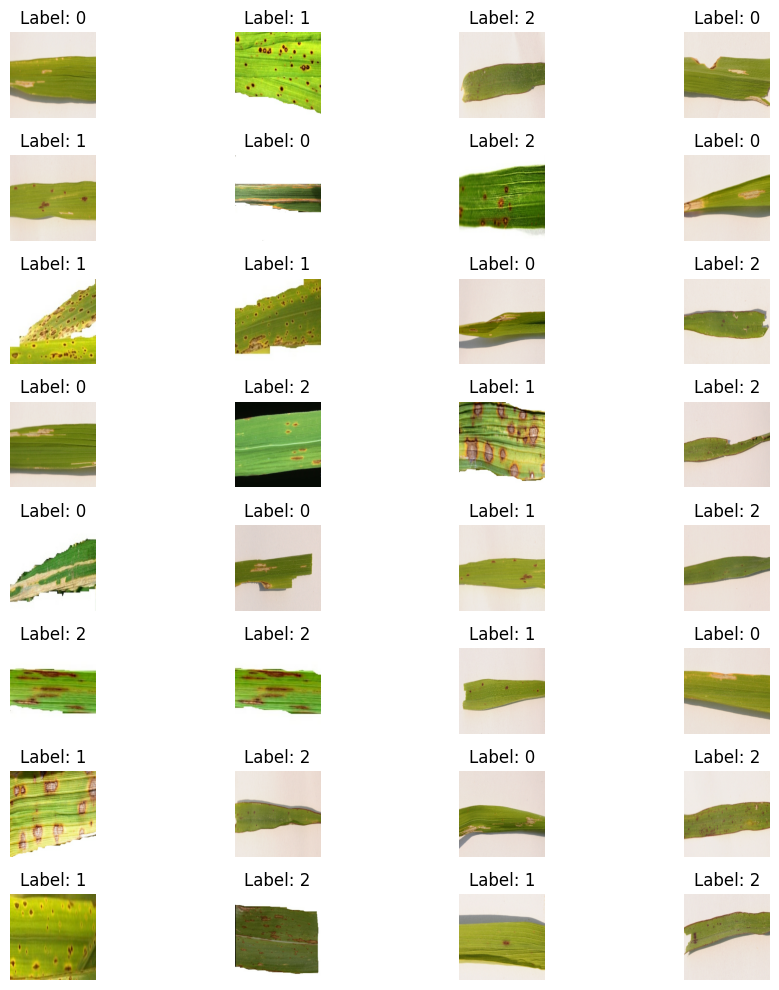

In [7]:
batched_ds = data.batch(batch_size)

batch = next(iter(batched_ds))
images, labels = batch

images, labels = next(iter(batched_ds))
show_images(images, labels)

 **Domain analysis**:

Some of the major rice diseases that affect rice plants include bacterial leaf blight, brown spot, and leaf smut.

Bacterial leaf blight: caused by the bacterium Xanthomonas oryzae pv. oryzae, is a serious disease that can cause extensive damage to rice plants. The symptoms of bacterial leaf blight include water-soaked lesions on the leaves, which later turn brown and dry up. In severe cases, the disease can cause wilting and death of the plant, leading to a significant reduction in crop yield

Brown spot: caused by the fungus Cochliobolus miyabeanus, is another major rice disease that can cause significant yield losses. The disease is characterized by small, oval to elliptical spots on the leaves, which turn brown with a yellow halo. In severe cases, the spots can coalesce and cause the leaves to wither and die. Brown spot can also affect the panicles, leading to a reduction in grain quality and yield

Leaf smut: caused by the fungus Entyloma oryzae, is a relatively less common rice disease. The symptoms of leaf smut include the formation of small, round, and reddish-brown spots on the leaves. These spots later turn black and produce powdery spores. Although leaf smut does not usually cause significant yield losses, it can affect the quality of rice grains by reducing their weight and size

**Data analysis**:

This data contains total 119 images

Both Bacterial_leaf_blight and brown spot have 40 images and 39 images of leaf smut

# Data preprocessing

* Data Spliting

In [6]:
X=[]
y= []

for image, label in data.batch(119):
  for img, lab in zip(image, label):
    X.append(img)
    y.append(lab.numpy())

In [7]:
X= np.array(X)
y= np.array(y)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)


* Scaling

In [9]:
X_train = X_train/255
X_test = X_test/255

In [10]:
print("shape of X_train_scaled:", X_train.shape)
print("shape of y_train:", y_train.shape)
print("shape of X_test_scaled:", X_test.shape)
print("shape of y_test:", y_test.shape)

shape of X_train_scaled: (89, 224, 224, 3)
shape of y_train: (89,)
shape of X_test_scaled: (30, 224, 224, 3)
shape of y_test: (30,)


* Encoding

In [11]:
y_train = to_categorical(y_train, num_classes=len(class_names))
y_test = to_categorical(y_test, num_classes=len(class_names))

# **Model creation**

In [12]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu',
                        input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))


model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))


model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(500, activation='relu'))

model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      208       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      2080      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 64)        0

In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [103]:
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', save_best_only=True)

history=model.fit(X_train, y_train,
                  validation_data= (X_test, y_test),
                  epochs=epochs,
                  callbacks=[checkpointer],verbose=1
                )

Epoch 1/30
3/3 [==============================] - 8s 2s/step - loss: 1.1834 - accuracy: 0.3933 - val_loss: 1.0765 - val_accuracy: 0.3667
Epoch 2/30
3/3 [==============================] - 5s 2s/step - loss: 1.1057 - accuracy: 0.3258 - val_loss: 1.0771 - val_accuracy: 0.3667
Epoch 3/30
3/3 [==============================] - 7s 3s/step - loss: 1.0863 - accuracy: 0.3371 - val_loss: 1.0680 - val_accuracy: 0.3667
Epoch 4/30
3/3 [==============================] - 5s 2s/step - loss: 1.0669 - accuracy: 0.3933 - val_loss: 1.0481 - val_accuracy: 0.4667
Epoch 5/30
3/3 [==============================] - 5s 2s/step - loss: 1.0241 - accuracy: 0.4607 - val_loss: 0.9949 - val_accuracy: 0.4667
Epoch 6/30
3/3 [==============================] - 7s 3s/step - loss: 0.9744 - accuracy: 0.5281 - val_loss: 0.9206 - val_accuracy: 0.5667
Epoch 7/30
3/3 [==============================] - 6s 2s/step - loss: 0.9358 - accuracy: 0.6180 - val_loss: 0.8630 - val_accuracy: 0.6667
Epoch 8/30
3/3 [=========================

In [104]:
y_hat = model.predict(X_test)


1/1 [==============================] - 1s 525ms/step


In [105]:
# evaluate test accuracy
score = model.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 83.3333%


In [106]:
def plot_performance(model_name, acc, val_acc, loss, val_loss):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('{} : Loss'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.subplot(1,2,2)
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('{} : Accuracy'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')
  plt.tight_layout()

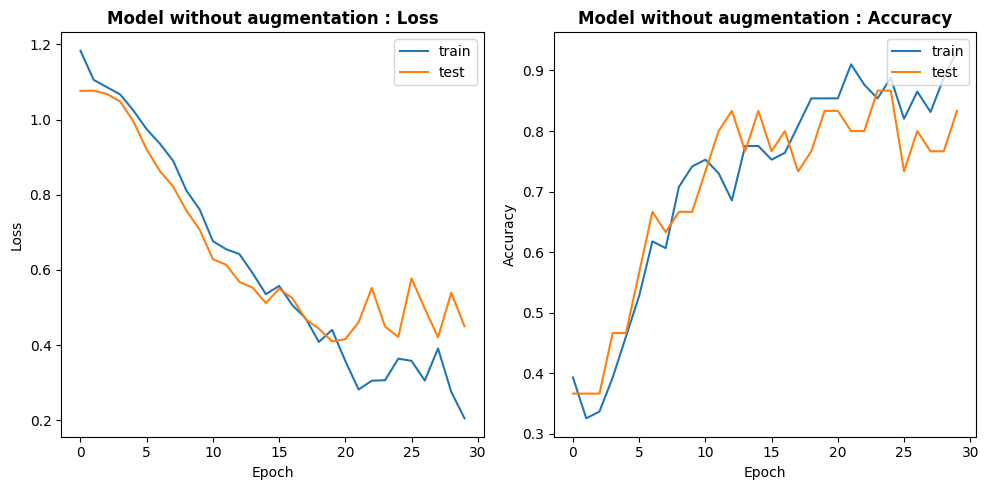

In [107]:
plot_performance(model_name= 'Model without augmentation',
                 acc=history.history['accuracy'],
                 val_acc=history.history['val_accuracy'],
                 loss=history.history['loss'],
                 val_loss=history.history['val_loss'])

* **Accuracy**:The training accuracy started at 0.3933 and reached 0.9326 at the final epoch, while the validation accuracy started at 0.3667 and reached 0.8333.
* The accuracy on the training set is gradually increases after 4th epoch
* The accuracy on the validation set  gradually improved after first 4 epochs,
 In some epochs the accuracy of validation data is higher than train data accuracy. This variance is continues till 17th epoch.
* Model prediction accuracy is 83.33
* **Loss**:The training loss started at 1.1834 and decreased gradually to 0.2048  at the final epoch, while the validation loss started at 1.0765 and decreased to 0.4499
 * The loss on the training set decreased gradually throughout the epochs, while the validation loss decreased steeply in the first few epochs and then slowed down.


The model was able to learn from the training data and improve its accuracy over time.
The performance on the validation set was also good, although there is some degree of overfitting. Hyperparameter tunning can help to overfitting problem.


visualising prediction

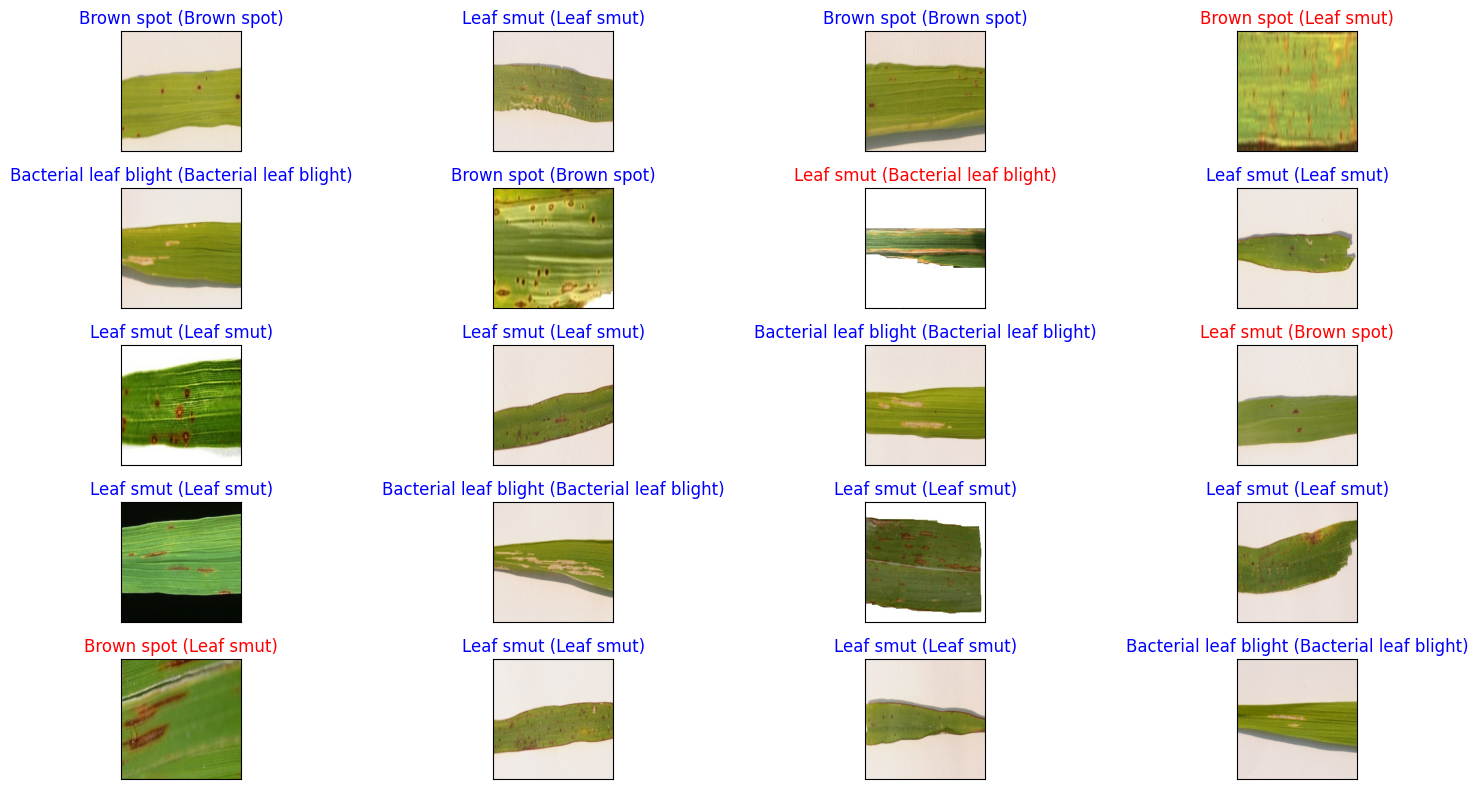

In [108]:
labels=data.class_names
fig = plt.figure(figsize=(20, 8))
for i, x in enumerate(np.random.choice(X_test.shape[0], size=20, replace=False)):
    ax = fig.add_subplot(5, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[x]))
    pred_x = np.argmax(y_hat[x])
    true_x = np.argmax(y_test[x])
    ax.set_title("{} ({})".format(labels[pred_x], labels[true_x]),
                 color=("blue" if pred_x == true_x else "red"))
    plt.tight_layout()

out of 20 ,16 predictions are correct

Model performance evaluation using Kfold

In [109]:
from sklearn.model_selection import KFold
num_folds = 5
acc_per_fold = []
loss_per_fold = []
kfold = KFold(n_splits=num_folds, shuffle=True)

In [110]:
# Merge inputs and targets
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

In [111]:
fold_no = 1
base_learning_rate = 0.0001

for train, test in kfold.split(X_train, y_train):
     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True) ,
              metrics=['accuracy'])
     print('------------------------------------------------------------------------')
     print(f'Training for fold {fold_no} ...')
     checkpointer1 = ModelCheckpoint(filepath='model_kfold.weights.best.hdf5', save_best_only=True)
     history=model.fit(X_train, y_train,
                  validation_data= (X_test, y_test),
                  epochs=epochs,
                  callbacks=[checkpointer1],verbose=1
                )
      # Generate generalization metrics
     scores = model.evaluate(inputs[test], targets[test], verbose=0)
     print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
     acc_per_fold.append(scores[1] * 100)
     loss_per_fold.append(scores[0])

     # Increase fold number
     fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/30
3/3 [==============================] - 7s 2s/step - loss: 0.1907 - accuracy: 0.9326 - val_loss: 0.4273 - val_accuracy: 0.8000
Epoch 2/30
3/3 [==============================] - 5s 2s/step - loss: 0.1474 - accuracy: 0.9663 - val_loss: 0.4549 - val_accuracy: 0.7333
Epoch 3/30
3/3 [==============================] - 7s 2s/step - loss: 0.1640 - accuracy: 0.9326 - val_loss: 0.4506 - val_accuracy: 0.7667
Epoch 4/30
3/3 [==============================] - 5s 2s/step - loss: 0.1314 - accuracy: 0.9438 - val_loss: 0.4095 - val_accuracy: 0.8000
Epoch 5/30
3/3 [==============================] - 5s 2s/step - loss: 0.0947 - accuracy: 0.9775 - val_loss: 0.3824 - val_accuracy: 0.8667
Epoch 6/30
3/3 [==============================] - 8s 3s/step - loss: 0.1145 - accuracy: 0.9663 - val_loss: 0.3699 - val_accuracy: 0.8667
Epoch 7/30
3/3 [==============================] - 5s 2s/step - loss: 0.0815 - acc

In [112]:
# == Provide average scores ==
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.02443113550543785 - Accuracy: 100.0%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.011354748159646988 - Accuracy: 100.0%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.0009930699598044157 - Accuracy: 100.0%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.00413260143250227 - Accuracy: 100.0%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.00029234084649942815 - Accuracy: 100.0%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 100.0 (+- 0.0)
> Loss: 0.008240779180778191
------------------------------------------------------------------------


In here we can see 100% accuracy so the model is overfitting.


In [131]:
model.load_weights('model_kfold.weights.best.hdf5')

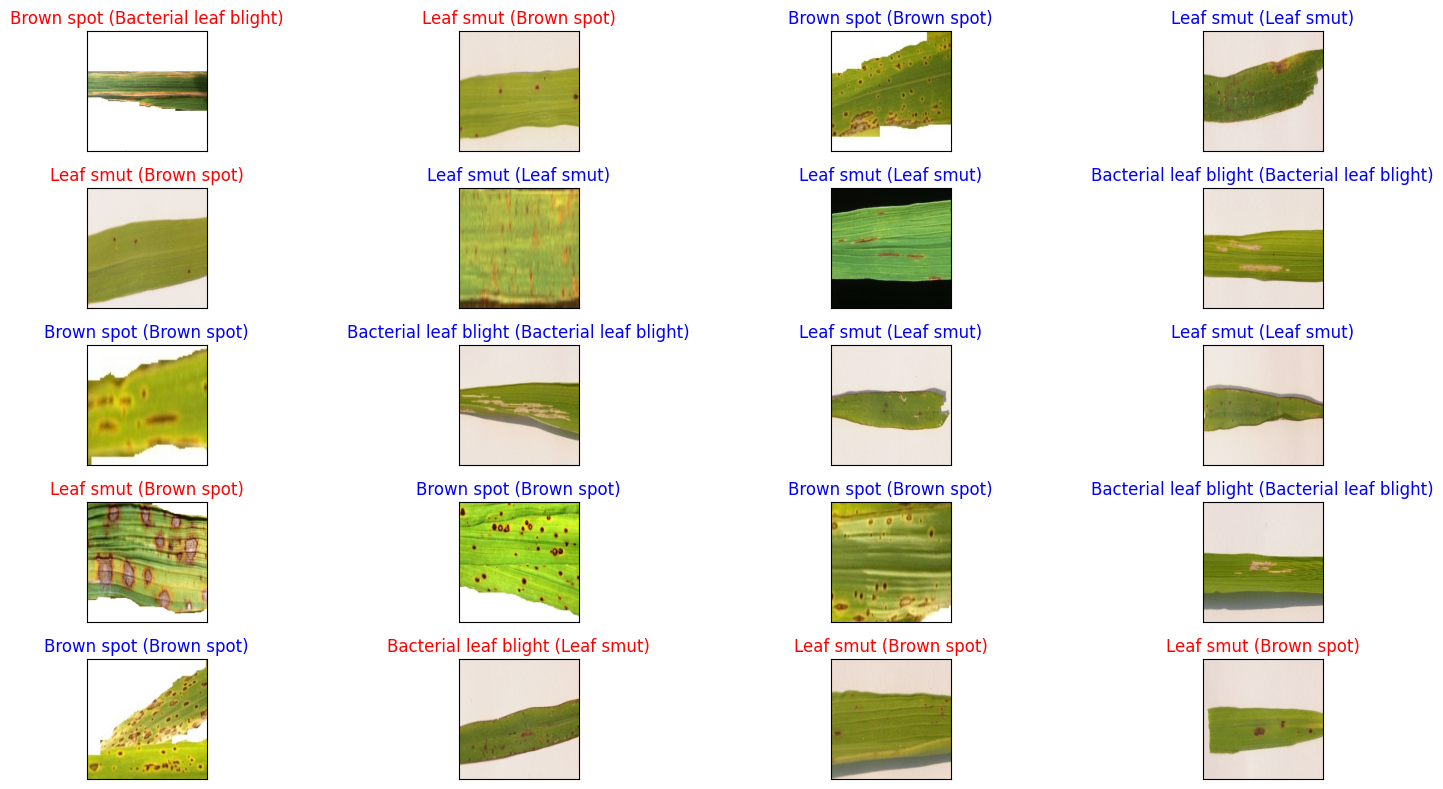

In [132]:
labels=data.class_names
fig = plt.figure(figsize=(20, 8))
for i, x in enumerate(np.random.choice(X_test.shape[0], size=20, replace=False)):
    ax = fig.add_subplot(5, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[x]))
    pred_x = np.argmax(y_hat[x])
    true_x = np.argmax(y_test[x])
    ax.set_title("{} ({})".format(labels[pred_x], labels[true_x]),
                 color=("blue" if pred_x == true_x else "red"))
    plt.tight_layout()

 We can see that in further training model is overfitting.

# Using Data augmentation

In [13]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect',
    validation_split=0.2)

In [114]:
checkpointer = ModelCheckpoint(filepath='model_aug.weights.best.hdf5', save_best_only=True)
aug_hist1=model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train)//batch_size,
    epochs=epochs,
    callbacks=[checkpointer],verbose=1)

Epoch 1/30
2/2 [==============================] - 5s 2s/step - loss: 6.6280 - accuracy: 0.5614 - val_loss: 0.8224 - val_accuracy: 0.9000
Epoch 2/30
2/2 [==============================] - 4s 2s/step - loss: 5.1848 - accuracy: 0.5938 - val_loss: 1.0011 - val_accuracy: 0.8667
Epoch 3/30
2/2 [==============================] - 7s 4s/step - loss: 4.8666 - accuracy: 0.5088 - val_loss: 1.1098 - val_accuracy: 0.8333
Epoch 4/30
2/2 [==============================] - 4s 2s/step - loss: 3.3485 - accuracy: 0.5965 - val_loss: 1.0372 - val_accuracy: 0.8000
Epoch 5/30
2/2 [==============================] - 7s 4s/step - loss: 3.1429 - accuracy: 0.4737 - val_loss: 0.9399 - val_accuracy: 0.7333
Epoch 6/30
2/2 [==============================] - 4s 2s/step - loss: 3.1742 - accuracy: 0.4737 - val_loss: 1.0145 - val_accuracy: 0.6333
Epoch 7/30
2/2 [==============================] - 7s 4s/step - loss: 2.5878 - accuracy: 0.4375 - val_loss: 1.0551 - val_accuracy: 0.5333
Epoch 8/30
2/2 [=========================

In [115]:
y_hat = model.predict(X_test)


1/1 [==============================] - 1s 841ms/step


In [116]:
score = model.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 66.6667%


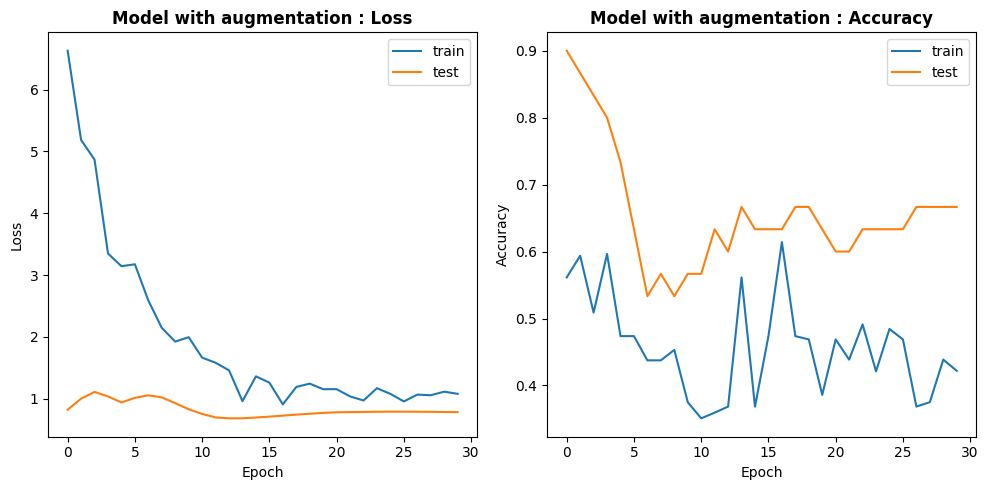

In [117]:
plot_performance(model_name= 'Model with augmentation',
                 acc=aug_hist1.history['accuracy'],
                 val_acc=aug_hist1.history['val_accuracy'],
                 loss=aug_hist1.history['loss'],
                 val_loss=aug_hist1.history['val_loss'])

* **Accuracy**:The training accuracy started at 0.5614 and reached 0.4219 at the final epoch, while the validation accuracy started at 0.9000 and reached 0.6667.

* **Loss**:The training loss started at 6.6280 and decreased gradually to 1.0789 at the final epoch, while the validation loss started at 0.8224 and decreased to 0.7832

* The accuracy of the model decreased significantly after the fourth epoch,this accuracy model fluctuated and didn't show a significant improvement over the base model.And model is not learning well
* The validation accuracy of the model decreased significantly till ninth epoch,then remained relatively stable for the rest of the epochs and didn't show a significant improvement over the baseline model.
* The training loss is decreases still 14 epoches, after that it slow down
* The validation loss remained relatively stable

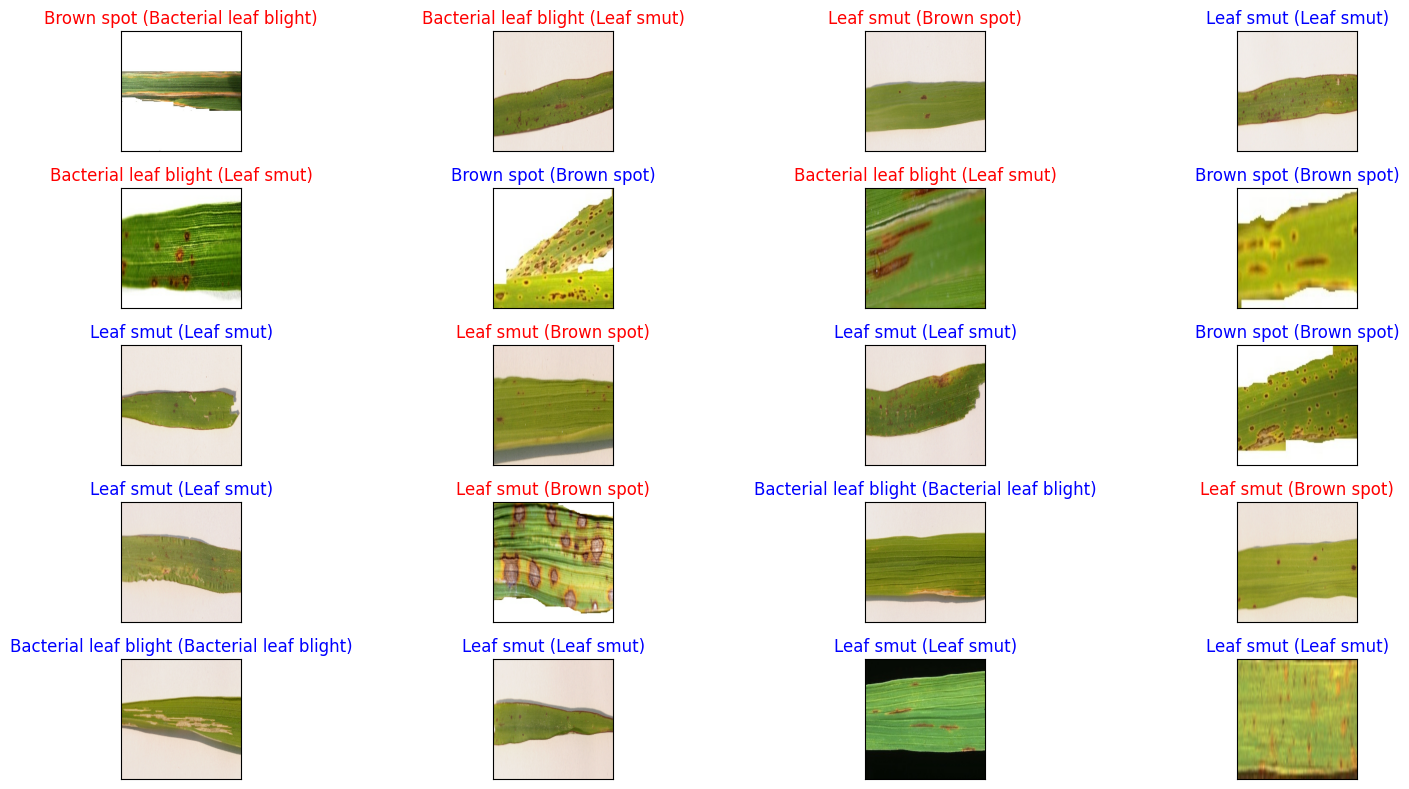

In [118]:
fig = plt.figure(figsize=(20, 8))
for i, x in enumerate(np.random.choice(X_test.shape[0], size=20, replace=False)):
    ax = fig.add_subplot(5, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[x]))
    pred_x = np.argmax(y_hat[x])
    true_x = np.argmax(y_test[x])
    ax.set_title("{} ({})".format(labels[pred_x], labels[true_x]),
                 color=("blue" if pred_x == true_x else "red"))
    plt.tight_layout()
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(X_test.shape[0], size=20, replace=False)):
    ax = fig.add_subplot(5, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "red"))
    plt.tight_layout()

out of 20, 12 predictions are right

Checking the model performance using kfold

In [119]:
fold_no = 1
base_learning_rate = 0.0001

for train, test in kfold.split(X_train, y_train):
     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True) ,
              metrics=['accuracy'])
     print('------------------------------------------------------------------------')
     print(f'Training for fold {fold_no} ...')
     checkpointer_model1aug = ModelCheckpoint(filepath='model_kfoldaug.weights.best.hdf5', verbose=3, save_best_only=True)
     aug_hist1=model.fit(
     datagen.flow(X_train, y_train, batch_size=batch_size),
     validation_data=(X_test, y_test),
     steps_per_epoch=len(X_train)//batch_size,
     epochs=epochs,
     callbacks=[checkpointer_model1aug],verbose=1)
      # Generate generalization metrics
     score = model.evaluate(inputs[test], targets[test], verbose=0)
     print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {score[0]}; {model.metrics_names[1]} of {score[1]*100}%')
     acc_per_fold.append(score[1] * 100)
     loss_per_fold.append(score[0])

     # Increase fold number
     fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/30
2/2 [==============================] - ETA: 0s - loss: 1.0754 - accuracy: 0.3684
Epoch 1: val_loss improved from inf to 0.81180, saving model to model_kfoldaug.weights.best.hdf5
2/2 [==============================] - 6s 3s/step - loss: 1.0754 - accuracy: 0.3684 - val_loss: 0.8118 - val_accuracy: 0.6667
Epoch 2/30
2/2 [==============================] - ETA: 0s - loss: 1.1100 - accuracy: 0.4035
Epoch 2: val_loss improved from 0.81180 to 0.79628, saving model to model_kfoldaug.weights.best.hdf5
2/2 [==============================] - 8s 4s/step - loss: 1.1100 - accuracy: 0.4035 - val_loss: 0.7963 - val_accuracy: 0.6667
Epoch 3/30
2/2 [==============================] - ETA: 0s - loss: 1.0830 - accuracy: 0.4531
Epoch 3: val_loss improved from 0.79628 to 0.78407, saving model to model_kfoldaug.weights.best.hdf5
2/2 [==============================] - 5s 2s/step - loss: 1.0830 - accuracy:

In [121]:
# == Provide average scores ==
print('Score per fold')
for i in range(5, 10):

  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold[i])} (+- {np.std(acc_per_fold[i])})')
print(f'> Loss: {np.mean(loss_per_fold[i])}')
print('------------------------------------------------------------------------')

Score per fold
------------------------------------------------------------------------
> Fold 6 - Loss: 0.5953266620635986 - Accuracy: 88.88888955116272%
------------------------------------------------------------------------
> Fold 7 - Loss: 0.2577366232872009 - Accuracy: 94.44444179534912%
------------------------------------------------------------------------
> Fold 8 - Loss: 0.27830299735069275 - Accuracy: 83.33333134651184%
------------------------------------------------------------------------
> Fold 9 - Loss: 0.3337547481060028 - Accuracy: 83.33333134651184%
------------------------------------------------------------------------
> Fold 10 - Loss: 0.15179330110549927 - Accuracy: 94.11764740943909%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 94.11764740943909 (+- 0.0)
> Loss: 0.15179330110549927
------------------------------------------------------------------------


* More training will helps model to learn better and perform well.
* we can see that in every iter the model is performing well both validation and training accuracy is improving.And best model saved into 'model_kfoldaug.weights.best.hdf5'.
* After hyperparameter tuning model performance will increase

In [127]:
model.load_weights('model_kfoldaug.weights.best.hdf5')

Visualising prediction applying kfold in augmented data

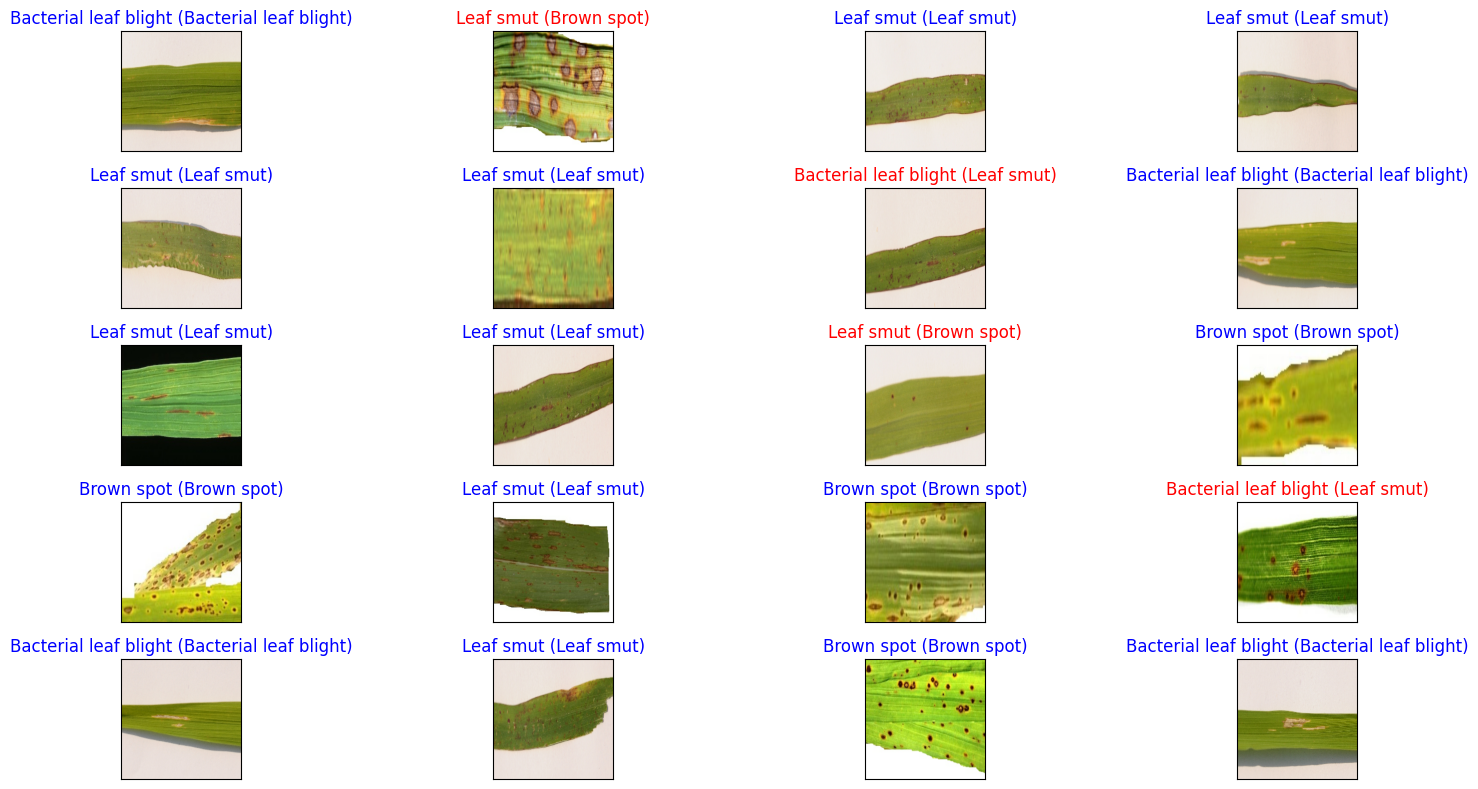

In [128]:
fig = plt.figure(figsize=(20, 8))
for i, x in enumerate(np.random.choice(X_test.shape[0], size=20, replace=False)):
    ax = fig.add_subplot(5, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[x]))
    pred_x = np.argmax(y_hat[x])
    true_x = np.argmax(y_test[x])
    ax.set_title("{} ({})".format(labels[pred_x], labels[true_x]),
                 color=("blue" if pred_x == true_x else "red"))
    plt.tight_layout()

out of 20 images ,16 are correct prediction

 **Model Comparison**

--> **Without Augmentation**:
* Accuracy:The training accuracy started at 0.3933 and reached 0.9326 at the final epoch, while the validation accuracy started at 0.3667 and reached 0.8333.
 * The accuracy on the training set is gradually increases after 4th epoch
 * The accuracy on the validation set gradually improved after first 4 epochs, In some epochs the accuracy of validation data is higher than train data accuracy. This variance is continues till 17th epoch.
* Loss:The training loss started at 1.1834 and decreased gradually to 0.2048 at the final epoch, while the validation loss started at 1.0765 and decreased to 0.4499
 *The loss on the training set decreased gradually throughout the epochs, while the validation loss decreased steeply in the first few epochs and then slowed down.
* After applying KFold we can clearly see that model is overfitting
* One of the reason for overfitting is less images in data

--> **With augmentation**:
* Accuracy:The training accuracy started at 0.5614 and reached 0.4219 at the final epoch, while the validation accuracy started at 0.9000 and reached 0.6667.
 * The accuracy of the model decreased significantly after the fourth epoch,this accuracy model fluctuated and didn't show a significant improvement over the base model.
 * The validation accuracy of the model decreased significantly till ninth epoch,then remained relatively stable for the rest of the epochs and didn't show a significant improvement over the baseline model.
* Loss:The training loss started at 6.6280 and decreased gradually to 1.0789 at the final epoch, while the validation loss started at 0.8224 and decreased to 0.7832
 * The training loss is decreases still 14 epoches, after that it slow down
 * The validation loss remained relatively stable
* After applying Kfold,
  we can see that in every iter the model is performing well both validation and training accuracy is improving.
* After hyperparameter tuning model performance will increase

**Conclusion**:
*  Augmented data model performs well but it learns slowly but accuracy increases according to the epoches (can seen in agumented kfold) and performs well.The difference is visible in the two prediction visualization in agumentation section.
* Without augmentation data tends to overfitting because of less data image.
* Augmentation is a important process in modeling

# **Report**

* One of the biggest challenges in the project was the limited amount of data available for training the models. We had only 119 images from 3 classes. This could lead to overfitting
* First created model is not learning well . Accuracy of both traning and validation is not improving and validation accuracy remained stable for every epoch even after applying techniques mobilenetv2,kfold,ensamble method
* For first time, Pathlib and glob used to create a list of images after created a dictionary using the lists.And this approach doesn't worked on my colab because it get crash every time after applying encoding using to_categorical().And tried with one hot encoding and manual encoding but data is not learning and couldn't apply the output dense layer with value of number of classes
* Needed to research a lot for to solve that issue
* after so many method, applied tf.keras.utils.image_dataset_from_directory  to load data  and encoded data using to_categorical().And assigned value 3 for output dense layer
